# Random Forest Model using TF/IDF

This model will integrate stories from the Guardian dataset with the original dataset and retrain the model.  The true stories will be split 50/50 between the original true stories and stories from the Guardian set.  The total number of true stories will be equal to the Fake ones to avoid class imbalance.

# Imports and Constants

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, plot_confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import ast
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.preprocessing import LabelBinarizer
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import model_helper_functions
from sklearn.model_selection import GridSearchCV
import pickle
import os

In [2]:
DATA_PATH = '../data/'
PRE_PROCESSED_DATA_FILE_NAME = 'news_dataset_pre_processed.csv'
GUARDIAN_DATA_FILE_NAME = 'guardian_news_dataset_cleaned.csv'
RANDOM_STATE = 42
pd.options.display.max_seq_items = 20
pd.options.display.max_rows = 50

In [34]:
SAVE_MODEL = False

MODEL_PATH = '../models/'
MODEL_FILE_NAME = 'rf_tfidf_plus_guardian_model.sav'

# Load Data

In [4]:
df = pd.read_csv(DATA_PATH + PRE_PROCESSED_DATA_FILE_NAME, 
                 low_memory = False, 
                 usecols = ['title', 'text', 'label', 'clean_text_tokens', 'clean_title_tokens'])

In [5]:
df.clean_text_tokens = df.clean_text_tokens.map(ast.literal_eval)
df.clean_title_tokens = df.clean_title_tokens.map(ast.literal_eval)

In [6]:
df.head()

,title,text,label,clean_text_tokens,clean_title_tokens
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,fake,"[donald, trump, just, couldn, wish, all, ameri...","[donald, trump, sends, out, embarrassing, new,..."
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,fake,"[house, intelligence, committee, chairman, dev...","[drunk, bragging, trump, staffer, started, rus..."
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",fake,"[on, it, was, revealed, that, former, milwauke...","[sheriff, david, clarke, becomes, an, internet..."
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",fake,"[on, christmas, day, donald, trump, announced,...","[trump, is, so, obsessed, he, even, has, obama..."
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,fake,"[pope, francis, used, his, annual, christmas, ...","[pope, francis, just, called, out, donald, tru..."


In [7]:
df_guard = pd.read_csv(DATA_PATH + GUARDIAN_DATA_FILE_NAME, 
                 low_memory = False)

In [8]:
df_guard.tt_tokens = df_guard.tt_tokens.map(ast.literal_eval)

# Integrate Guardian Stories as true

## split original data by label

In [9]:
df_fake = df[df.label == 'fake']

In [10]:
df_true_og = df[df.label == 'true']

In [11]:
len(df_fake)/2

8723.5

## Take Random Sample of original true data

Equal to half of fake data so to keep the classes balanced

In [12]:
df_true_og_sample = df_true_og.sample(8724, random_state = RANDOM_STATE)

## Take Random Sample of Guardian data

In [13]:
df_guard_sample = df_guard.sample(8723, random_state = RANDOM_STATE)

### Assign the label true

In [14]:
df_guard_sample['label'] = 'true'

## Combine datasets

In [15]:
df_true_og_sample['tt_tokens'] = df_true_og_sample['clean_title_tokens'] + df_true_og_sample['clean_text_tokens']

In [16]:
df_fake['tt_tokens'] = df_fake['clean_title_tokens'] + df_fake['clean_text_tokens']

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [17]:
df_all = pd.concat([df_fake[['label', 'tt_tokens']], 
                         df_true_og_sample[['label', 'tt_tokens']], 
                        df_guard_sample[['label', 'tt_tokens']]], axis=0)

# Split Data

In [18]:
y = df_all.label
X = df_all.drop('label', axis=1)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                   test_size = 0.2,
                                                   random_state = RANDOM_STATE,
                                                   stratify = y)

In [20]:
X_train.shape

(27915, 1)

In [21]:
X_test.shape

(6979, 1)

# Encode Labels

In [22]:
le = LabelEncoder()

In [23]:
y_train_enc = le.fit_transform(y_train)

In [24]:
y_test_enc = le.transform(y_test)

# Train Models

In [25]:
def train_and_eval_model(X_train, X_test, y_train_enc, y_test_enc, classes_,
                        preprocessor, tokenizer, max_df=1.0, ngram_range = (1, 1),
                        min_samples_split=2,
                        max_depth=None):
    """
    Train and Evaluate and Bag of Words Representation with a Random Forest
    classifier.
    """
    
    pipeline = Pipeline([
    ('bow',CountVectorizer(min_df = 5, 
                           preprocessor = preprocessor, 
                           tokenizer = tokenizer, 
                           max_df = max_df, 
                           ngram_range = ngram_range)),
    ('tfidf', TfidfTransformer()),
    ('classifier', RandomForestClassifier(n_jobs = -1, 
                                          random_state = RANDOM_STATE, 
                                          min_samples_split = min_samples_split, 
                                          max_depth = max_depth)),
    ])
    
    pipeline.fit(X_train,y_train_enc)
    
    model_helper_functions.confustion_matrix_and_classification_report(pipeline, 
                                                X_train, 
                                                y_train_enc, 
                                                classes_, 
                                               'Training')

    model_helper_functions.confustion_matrix_and_classification_report(pipeline, 
                                                X_test, 
                                                y_test_enc, 
                                                classes_,
                                                'Test')
    
    return pipeline

## Title & Text only - lowercase, only stopwords, but a larger set of them.

In [26]:
# using expanded stopwords list from https://gist.github.com/sebleier/554280

gist_file = open(DATA_PATH + "gist_stopwords.txt", "r")
try:
    content = gist_file.read()
    expanded_stopwords = content.split(",")
finally:
    gist_file.close()

Remove 'via' from the list of stopwords b/c it is particular to this dataset.

In [27]:
expanded_stopwords.remove('via')

Remove UK specific terms that are affecting the model

In [28]:
expanded_stopwords.remove('eu')
expanded_stopwords.remove('uk')

In [29]:
def lowercase_and_only_expanded_stopwords(doc):
    """Remove stopwords and lowercase tokens"""
    stop_words = expanded_stopwords
    return [token.lower() for token in doc if token.lower() in stop_words]

Classification Report for Training Set
              precision    recall  f1-score   support

        fake       0.92      0.96      0.94     13957
        true       0.96      0.92      0.94     13958

    accuracy                           0.94     27915
   macro avg       0.94      0.94      0.94     27915
weighted avg       0.94      0.94      0.94     27915



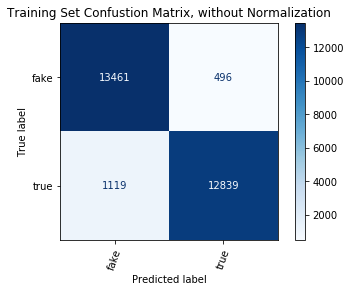

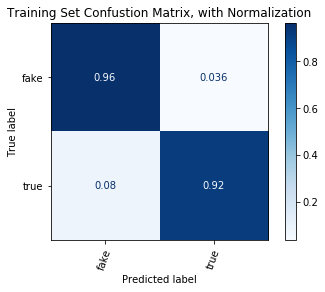

Classification Report for Test Set
              precision    recall  f1-score   support

        fake       0.88      0.91      0.89      3490
        true       0.90      0.88      0.89      3489

    accuracy                           0.89      6979
   macro avg       0.89      0.89      0.89      6979
weighted avg       0.89      0.89      0.89      6979



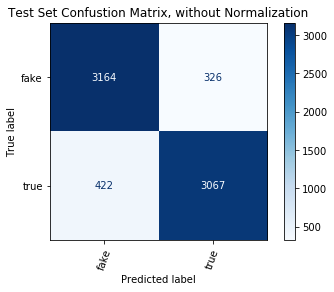

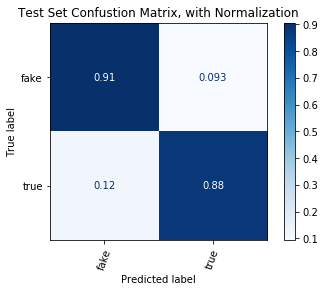

In [30]:
pipe_expanded_sw_no_via = train_and_eval_model(X_train['tt_tokens'], 
                                                        X_test['tt_tokens'],
                                                        y_train_enc, 
                                                        y_test_enc, 
                                                        le.classes_, 
                                                        lowercase_and_only_expanded_stopwords, 
                                                        model_helper_functions.passthrough,
                                                 min_samples_split = 0.005)

In [31]:
feat_imp_expanded_sw_no_via = pd.DataFrame(pipe_expanded_sw_no_via['classifier'].feature_importances_, 
                                       index = pipe_expanded_sw_no_via['bow'].get_feature_names(), 
                                       columns = ['importance']).sort_values('importance', 
                                                                             ascending=False)
feat_imp_expanded_sw_no_via.head(30)

,importance
said,0.124759
the,0.040807
its,0.040782
just,0.040064
this,0.032734
on,0.030779
you,0.029564
like,0.024284
in,0.023287
would,0.019989


# Save Model

In [32]:
try: 
    os.mkdir(MODEL_PATH)
except FileExistsError:
    print('Model directory already exists')
    pass

Model directory already exists


In [33]:
if SAVE_MODEL:
    pickle.dump(pipe_expanded_sw_no_via, open(MODEL_PATH + MODEL_FILE_NAME, 'wb'))

# Summary

The accuracy and F1 scores for this model are somewhat worse than the model trained on the original dataset, 0.89 here vs. 0.94, but this model should generalize better because the news stories labeled true came from more than one news source.